In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from datetime import datetime
from paths import *
import igraph as ig
from collections import defaultdict

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
df_comments = pd.read_csv('F:\\3 course\\css\\ExploringReddit\\data\\joined_comments.csv')
df_submissions = pd.read_csv('F:\\3 course\\css\\ExploringReddit\\data\\joined_submissions.csv')

In [5]:
df_comments.head()

,author,subreddit,score,created,link,body
0,u/lisztomania_0,AskMiddleEast,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,It is an über talent that has become an über t...
1,u/JakeTheSandMan,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,“Armada” \n\nI prefer to call them floating hu...
2,u/justnmirrrs,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,"70% of France electricity is nuclear, so it co..."
3,u/liquid_cherry,worldnews,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/worldnews/comments/15...,In the United States you can burn the Bible an...
4,u/Grouchy-Bad-4190,AskMiddleEast,0.063841,2023-08-01 03:00:00,https://www.reddit.com/r/AskMiddleEast/comment...,Good


In [6]:
df_submissions.head()

,author,subreddit,title,num_comments,score,over_18,created,link,text,url
0,u/BurstYourBubbles,worldnews,"S. Korean, Italian FMs hold talks on boosting ...",0.000150,0.000019,False,2023-08-01 03:24,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://en.yna.co.kr/view/AEN20230801001000325?
1,u/BurstYourBubbles,worldnews,Hong Kong gov't would face 'difficulty' if it ...,0.000075,0.000019,False,2023-08-01 03:26,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://hongkongfp.com/2023/08/01/hong-kong-go...
2,u/kurdishgun,AskMiddleEast,Thoughts on exmuslim?,0.004198,0.000019,False,2023-08-01 03:31,https://www.reddit.com/r/AskMiddleEast/comment...,NaN,https://i.redd.it/mmy60for8efb1.png
3,u/TypicalHorror9,worldnews,Professional dancer pumping gas in NYC stabbed...,0.000000,0.000019,False,2023-08-01 03:41,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://www.nydailynews.com/new-york/nyc-crime...
4,u/mrwhiskeyrum,worldnews,Frequent dispatch of ships and aircraft by cer...,0.000899,0.000019,False,2023-08-01 03:44,https://www.reddit.com/r/worldnews/comments/15...,NaN,https://newsinfo.inquirer.net/1809492/foreign-...


Для наступних досліджень для зручності додамо стовбці

In [49]:
sia = SentimentIntensityAnalyzer()

df_comments['compound'] = df_comments['body'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

df_submissions['compound'] = df_submissions['title'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

from urllib.parse import urlparse

df_submissions['domain'] = df_submissions['url'].apply(lambda x: urlparse(str(x)).netloc if pd.notnull(x) else '')

# Для тесту
df_submissions[['subreddit','url','domain']].head()


### 1. Correlation: Israel-Gaza Conflict and r/worldnews Commenting Activity

Those charts track the daily volume of unique comments posted on the r/worldnews subreddit. They highlight a strong and direct correlation between a major geopolitical event and online engagement.

First one shows the total daily volume of all unique comments submitted to the r/worldnews subreddit, regardless of topic, demonstrating the overall community reaction to the crisis.

The second chart (below) refines this view by only including comments that explicitly mention keywords related to the conflict (Gaza, Palestine, Israel, Hamas), thereby isolating the volume of discussion specifically centered on this event.


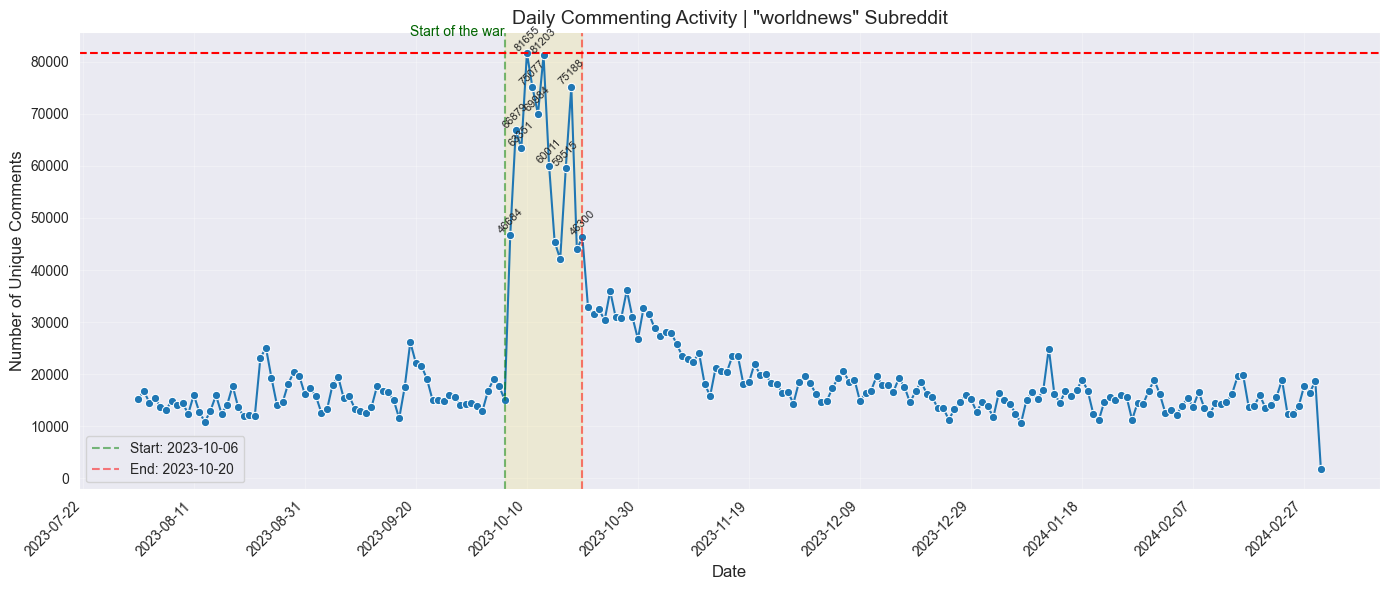

In [7]:
filtered_df = df_comments[df_comments['subreddit'] == 'worldnews'].copy()
filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')

filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

daily_counts = filtered_df['date'].value_counts().sort_index()
daily_counts_df = daily_counts.reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Comment_Count', data=daily_counts_df, marker='o')

threshold = daily_counts_df['Comment_Count'].quantile(0.95)

above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

first_date = above_threshold['Date'].min() - timedelta(days=1)
last_date = above_threshold['Date'].max()

plt.axvline(first_date, color='green', linestyle='--', alpha=0.5, label=f'Start: {first_date}')
plt.axvline(last_date, color='red', linestyle='--', alpha=0.5, label=f'End: {last_date}')
plt.axvspan(first_date, last_date, color='khaki', alpha=0.3)

plt.text(first_date, daily_counts_df['Comment_Count'].max() * 1.05, 'Start of the war',
         color='darkgreen', ha='right', va='center', fontsize=10, rotation=0)

for idx, row in daily_counts_df.iterrows():
    if row['Comment_Count'] > threshold:
        plt.text(row['Date'], row['Comment_Count'], str(row['Comment_Count']),
                ha='center', va='bottom', fontsize=8, rotation=45)

plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))  # Max 15 date labels
plt.axhline(y=daily_counts_df['Comment_Count'].max(), color='r', linestyle='--')

plt.title('Daily Commenting Activity | "worldnews" Subreddit', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Comments', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

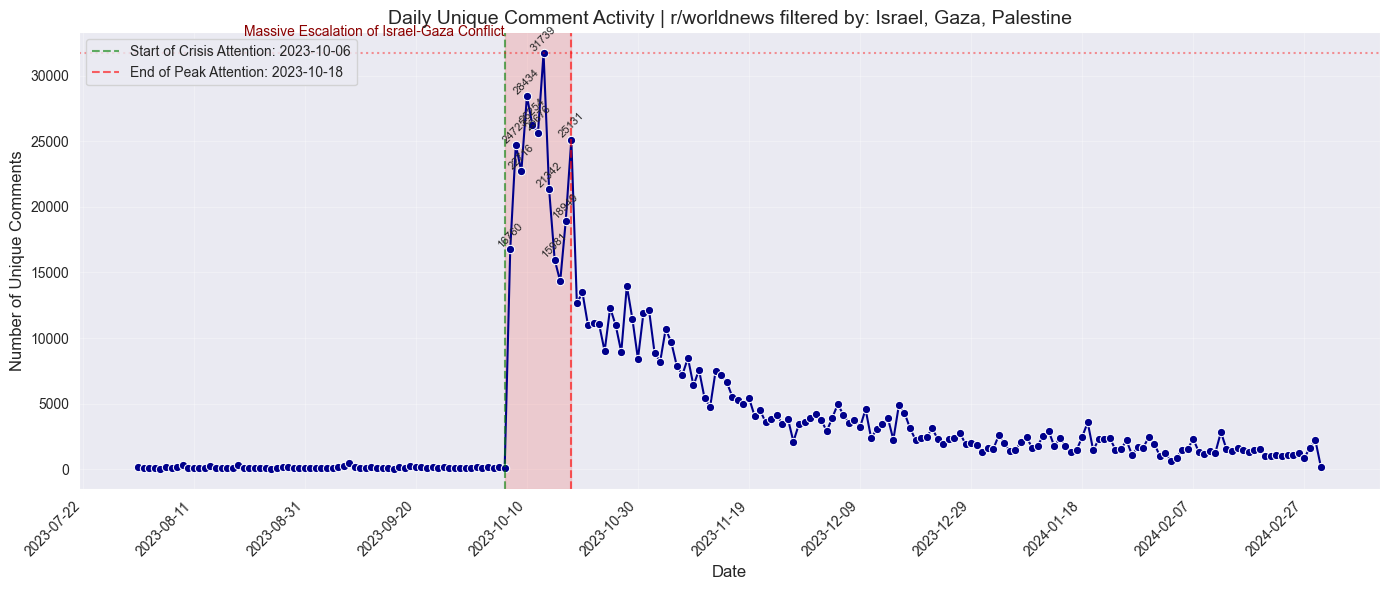

In [8]:
keywords = 'Gaza|Palestine|Israel|Hamas'

# Filtration
filtered_df = df_comments[
    (df_comments['subreddit'] == 'worldnews') &
    (df_comments['body'].str.contains(keywords, case=False, na=False))
].copy()

# date -> datetime
filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

# Unique comments count
daily_counts = filtered_df['date'].value_counts().sort_index()
daily_counts_df = daily_counts.reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']

# Visualisation
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Comment_Count', data=daily_counts_df, marker='o', color='darkblue')

threshold = daily_counts_df['Comment_Count'].quantile(0.95)
above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

if not above_threshold.empty:
    first_date = above_threshold['Date'].min() - timedelta(days=1)
    last_date = above_threshold['Date'].max()

    plt.axvline(first_date, color='green', linestyle='--', alpha=0.6, label=f'Start of Crisis Attention: {first_date}')
    plt.axvline(last_date, color='red', linestyle='--', alpha=0.6, label=f'End of Peak Attention: {last_date}')
    plt.axvspan(first_date, last_date, color='lightcoral', alpha=0.3)

    max_y = daily_counts_df['Comment_Count'].max()
    plt.text(first_date, max_y * 1.05, 'Massive Escalation of Israel-Gaza Conflict',
             color='darkred', ha='right', va='center', fontsize=10, rotation=0)

    for idx, row in daily_counts_df.iterrows():
        if row['Comment_Count'] > threshold:
            plt.text(row['Date'], row['Comment_Count'], str(row['Comment_Count']),
                    ha='center', va='bottom', fontsize=8, rotation=45)
else:
    print("Warning: Not enough data points exceeded the 95th percentile threshold to highlight a period.")


plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))

plt.axhline(y=daily_counts_df['Comment_Count'].max(), color='red', linestyle=':', alpha=0.4)

plt.title('Daily Unique Comment Activity | r/worldnews filtered by: Israel, Gaza, Palestine', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Unique Comments', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

#### 2. Sentiment Analysis of r/worldnews Discussions: "Israel" vs. "Palestine"

This line chart visualizes the Daily Average Compound Sentiment for comments on the r/worldnews subreddit, filtered for the keywords "Israel" and "Palestine," starting October 1, 2023. The Compound Sentiment ranges from -1 (most negative) to +1 (most positive).

**Key Timeline Markers:**

War Start (Oct 7, 2023): Marked by a vertical dashed red line, this point signifies the beginning of the major escalation of the conflict.

First 2 Weeks of War (Oct 7 - Oct 21): Shaded in light coral, this area highlights the sentiment during the initial, most intense phase of the conflict.

Zero Line (0.0): A horizontal dashed gray line separates overall positive sentiment (above) from negative sentiment (below).

**Observation:**

Based on the sustained trend following the initial shock, discussions containing the keyword "Israel" (blue line) trended at an equally negative or slightly more negative average compound sentiment than those containing "Palestine" (red line) throughout the majority of the subsequent two weeks.

This suggests that, for the extended period following the initial escalation, commentary in r/worldnews associated with "Israel" was frequently marked by a more critical, angry, or pessimistic tone compared to discussions involving "Palestine."

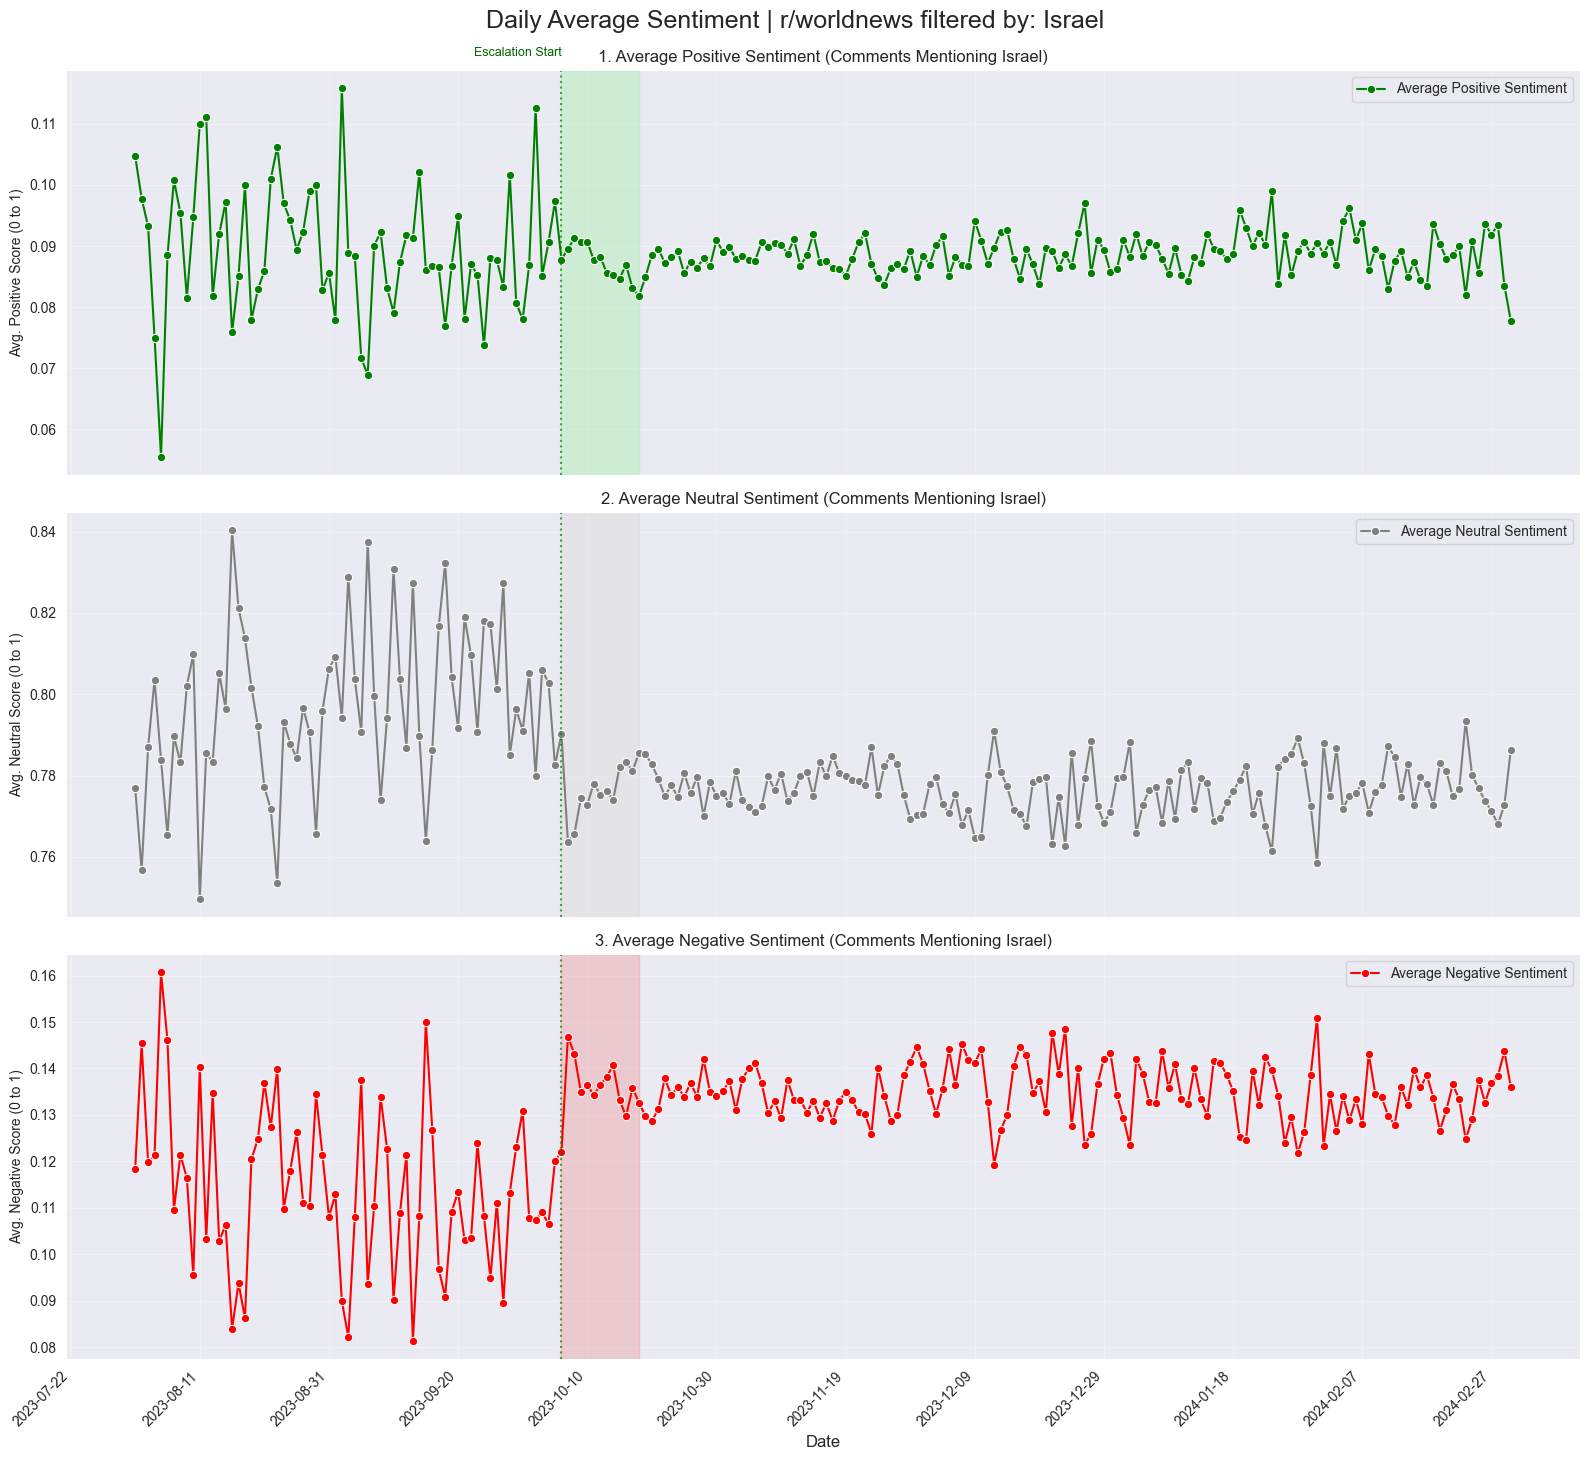

In [9]:
#мабуть видалити
# Filtration and analysis

keywords = 'Israel'

filtered_df = df_comments[
    (df_comments['subreddit'] == 'worldnews') &
    (df_comments['body'].str.contains(keywords, case=False, na=False))
].copy()

filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')
filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

sia = SentimentIntensityAnalyzer()

filtered_df['sentiment_scores'] = filtered_df['body'].apply(lambda x: sia.polarity_scores(str(x)))
filtered_df['Negative'] = filtered_df['sentiment_scores'].apply(lambda x: x['neg'])
filtered_df['Neutral'] = filtered_df['sentiment_scores'].apply(lambda x: x['neu'])
filtered_df['Positive'] = filtered_df['sentiment_scores'].apply(lambda x: x['pos'])

daily_sentiment = filtered_df.groupby('date')[['Positive', 'Neutral', 'Negative']].mean().reset_index()
daily_sentiment.columns = ['Date', 'Positive', 'Neutral', 'Negative']

daily_counts_df = filtered_df['date'].value_counts().reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']
threshold = daily_counts_df['Comment_Count'].quantile(0.95)
above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

first_date, last_date = None, None
if not above_threshold.empty:
    first_date = above_threshold['Date'].min() - timedelta(days=1)
    last_date = above_threshold['Date'].max()


# Visualisation
fig, axes = plt.subplots(3, 1, figsize=(16, 15), sharex=True)

plt.suptitle('Daily Average Sentiment | r/worldnews filtered by: Israel',
             fontsize=18, y=0.97)

# Positive
sns.lineplot(ax=axes[0], x='Date', y='Positive', data=daily_sentiment, color='green', marker='o', label='Average Positive Sentiment')
axes[0].set_title('1. Average Positive Sentiment (Comments Mentioning Israel)', fontsize=12)
axes[0].set_ylabel('Avg. Positive Score (0 to 1)')
axes[0].grid(True, alpha=0.3)
if first_date:
    axes[0].axvspan(first_date, last_date, color='lightgreen', alpha=0.3)
    axes[0].axvline(first_date, color='green', linestyle=':', alpha=0.7)
    axes[0].text(first_date, daily_sentiment['Positive'].max() * 1.05, 'Escalation Start',
                 color='darkgreen', ha='right', va='center', fontsize=9, rotation=0)

# Neutral
sns.lineplot(ax=axes[1], x='Date', y='Neutral', data=daily_sentiment, color='gray', marker='o', label='Average Neutral Sentiment')
axes[1].set_title('2. Average Neutral Sentiment (Comments Mentioning Israel)', fontsize=12)
axes[1].set_ylabel('Avg. Neutral Score (0 to 1)')
axes[1].grid(True, alpha=0.3)
if first_date:
    axes[1].axvspan(first_date, last_date, color='lightgray', alpha=0.3)
    axes[1].axvline(first_date, color='green', linestyle=':', alpha=0.7)

# Negative
sns.lineplot(ax=axes[2], x='Date', y='Negative', data=daily_sentiment, color='red', marker='o', label='Average Negative Sentiment')
axes[2].set_title('3. Average Negative Sentiment (Comments Mentioning Israel)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Avg. Negative Score (0 to 1)')
axes[2].grid(True, alpha=0.3)
if first_date:
    axes[2].axvspan(first_date, last_date, color='lightcoral', alpha=0.3)
    axes[2].axvline(first_date, color='green', linestyle=':', alpha=0.7)

plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.93)
plt.show()

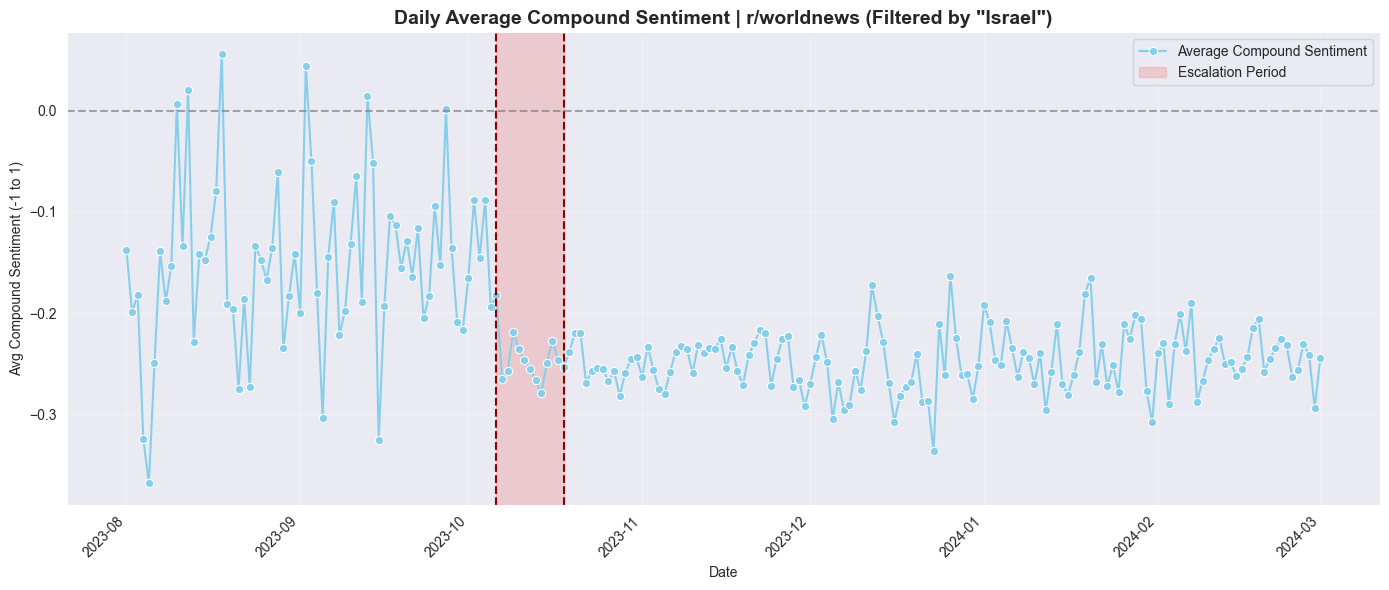

In [33]:
#мабуть видалити
keywords = 'Israel'
filtered_df = df_comments[
    (df_comments['subreddit'] == 'worldnews') &
    (df_comments['body'].str.contains(keywords, case=False, na=False))
].copy()
filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')
filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

daily_compound = filtered_df.groupby('date')['compound'].mean().reset_index()
daily_compound.columns = ['Date', 'Avg_Compound']

daily_counts = filtered_df['date'].value_counts().sort_index().reset_index()
daily_counts.columns = ['Date', 'Comment_Count']
threshold = daily_counts['Comment_Count'].quantile(0.95)
above_threshold = daily_counts[daily_counts['Comment_Count'] > threshold]
first_date, last_date = None, None
if not above_threshold.empty:
    first_date = above_threshold['Date'].min() - timedelta(days=1)
    last_date = above_threshold['Date'].max()

plt.figure(figsize=(14,6))
sns.lineplot(data=daily_compound, x='Date', y='Avg_Compound', marker='o', color='skyblue', label='Average Compound Sentiment')
if first_date:
    plt.axvspan(first_date, last_date, color='lightcoral', alpha=0.3, label='Escalation Period')
    plt.axvline(first_date, color='darkred', linestyle='--')
    plt.axvline(last_date, color='darkred', linestyle='--')
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.title('Daily Average Compound Sentiment | r/worldnews (Filtered by "Israel")', fontsize=14, weight='bold')
plt.xlabel('Date')
plt.ylabel('Avg Compound Sentiment (-1 to 1)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

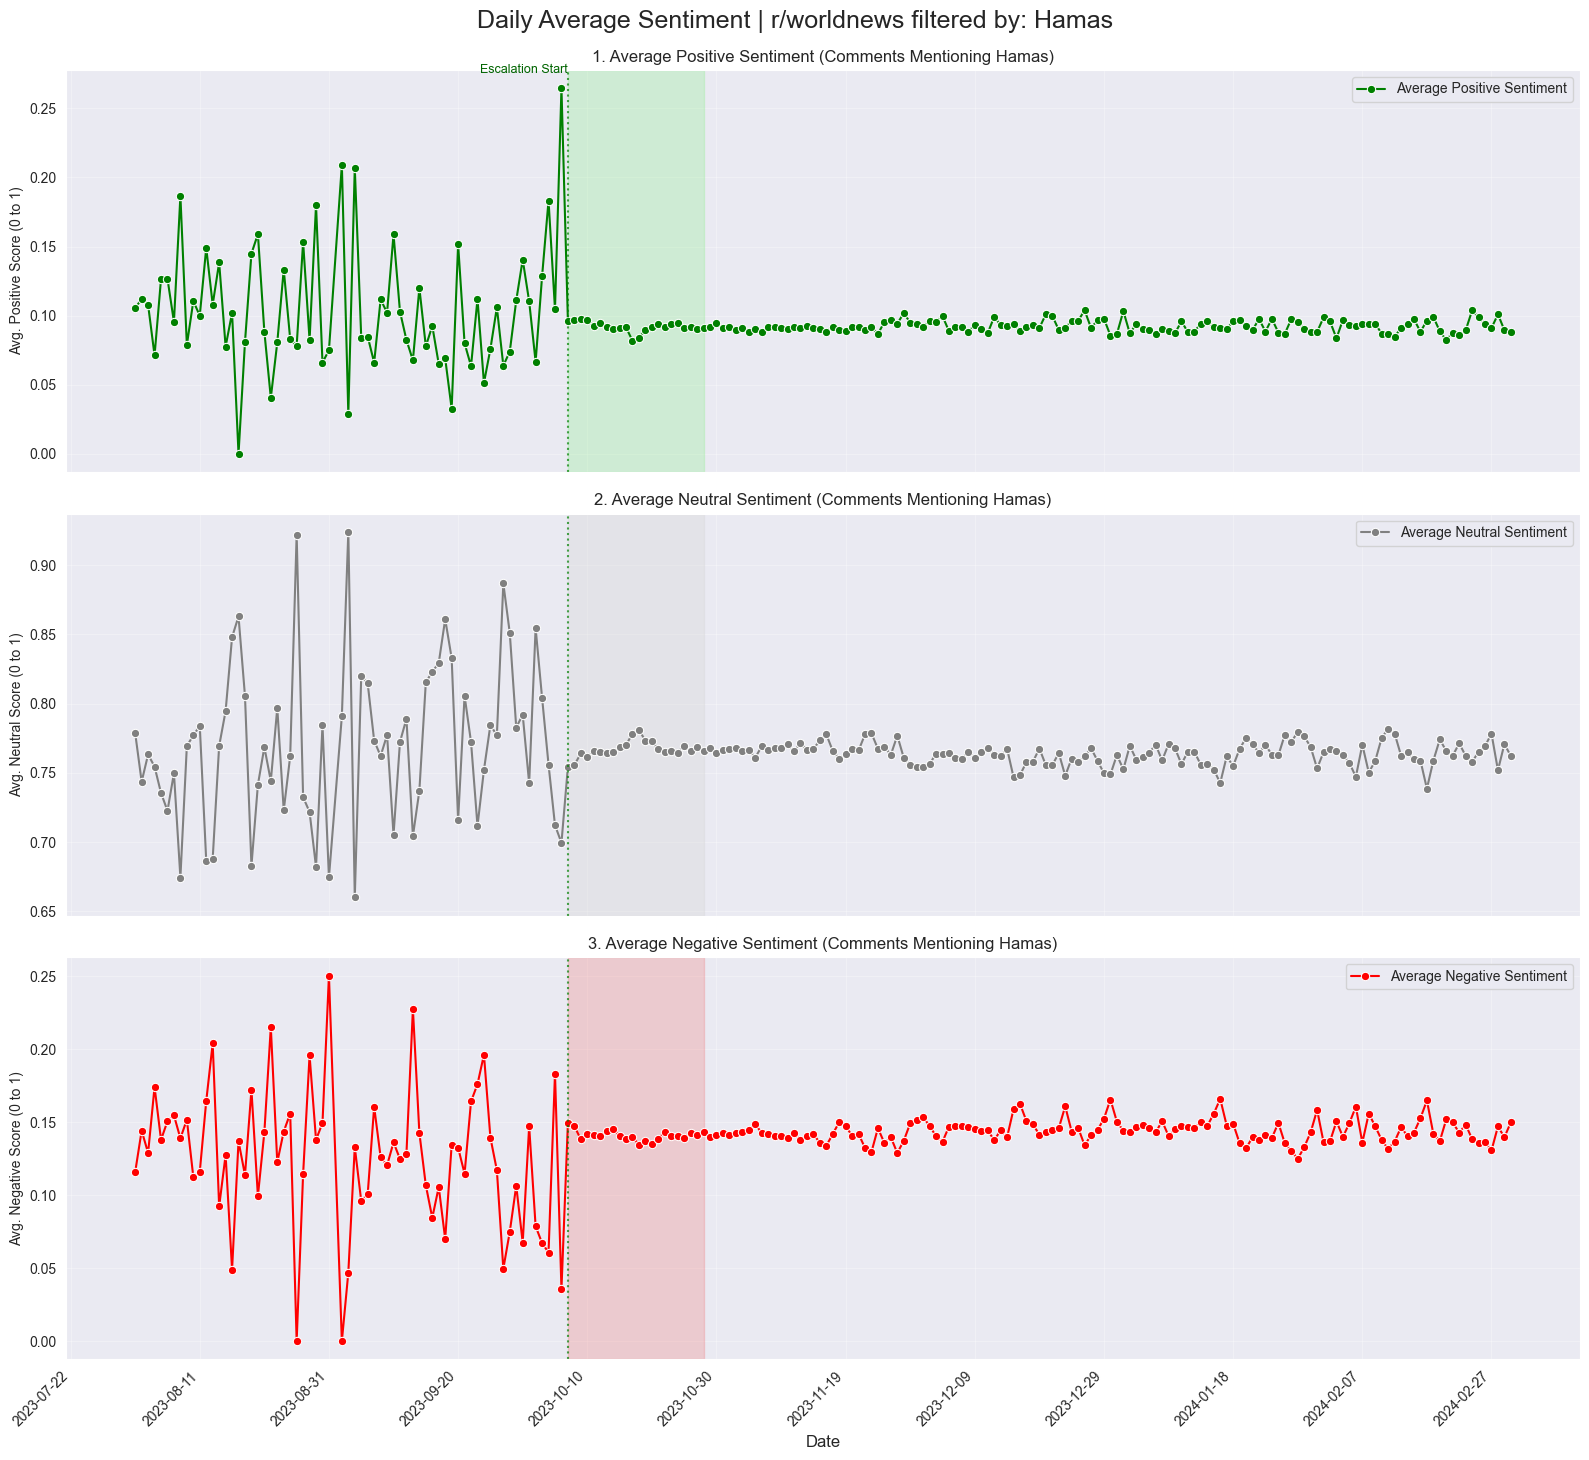

In [10]:
#мабуть видалити
# Filtration and analysis

keywords = 'Hamas'

filtered_df = df_comments[
    (df_comments['subreddit'] == 'worldnews') &
    (df_comments['body'].str.contains(keywords, case=False, na=False))
].copy()

filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')
filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

sia = SentimentIntensityAnalyzer()

filtered_df['sentiment_scores'] = filtered_df['body'].apply(lambda x: sia.polarity_scores(str(x)))
filtered_df['Negative'] = filtered_df['sentiment_scores'].apply(lambda x: x['neg'])
filtered_df['Neutral'] = filtered_df['sentiment_scores'].apply(lambda x: x['neu'])
filtered_df['Positive'] = filtered_df['sentiment_scores'].apply(lambda x: x['pos'])

daily_sentiment = filtered_df.groupby('date')[['Positive', 'Neutral', 'Negative']].mean().reset_index()
daily_sentiment.columns = ['Date', 'Positive', 'Neutral', 'Negative']

daily_counts_df = filtered_df['date'].value_counts().reset_index()
daily_counts_df.columns = ['Date', 'Comment_Count']
threshold = daily_counts_df['Comment_Count'].quantile(0.95)
above_threshold = daily_counts_df[daily_counts_df['Comment_Count'] > threshold]

first_date, last_date = None, None
if not above_threshold.empty:
    first_date = above_threshold['Date'].min() - timedelta(days=1)
    last_date = above_threshold['Date'].max()


# Visualisation
fig, axes = plt.subplots(3, 1, figsize=(16, 15), sharex=True)

plt.suptitle('Daily Average Sentiment | r/worldnews filtered by: Hamas',
             fontsize=18, y=0.97)

# Positive
sns.lineplot(ax=axes[0], x='Date', y='Positive', data=daily_sentiment, color='green', marker='o', label='Average Positive Sentiment')
axes[0].set_title('1. Average Positive Sentiment (Comments Mentioning Hamas)', fontsize=12)
axes[0].set_ylabel('Avg. Positive Score (0 to 1)')
axes[0].grid(True, alpha=0.3)
if first_date:
    axes[0].axvspan(first_date, last_date, color='lightgreen', alpha=0.3)
    axes[0].axvline(first_date, color='green', linestyle=':', alpha=0.7)
    axes[0].text(first_date, daily_sentiment['Positive'].max() * 1.05, 'Escalation Start',
                 color='darkgreen', ha='right', va='center', fontsize=9, rotation=0)

# Neutral
sns.lineplot(ax=axes[1], x='Date', y='Neutral', data=daily_sentiment, color='gray', marker='o', label='Average Neutral Sentiment')
axes[1].set_title('2. Average Neutral Sentiment (Comments Mentioning Hamas)', fontsize=12)
axes[1].set_ylabel('Avg. Neutral Score (0 to 1)')
axes[1].grid(True, alpha=0.3)
if first_date:
    axes[1].axvspan(first_date, last_date, color='lightgray', alpha=0.3)
    axes[1].axvline(first_date, color='green', linestyle=':', alpha=0.7)

# Negative
sns.lineplot(ax=axes[2], x='Date', y='Negative', data=daily_sentiment, color='red', marker='o', label='Average Negative Sentiment')
axes[2].set_title('3. Average Negative Sentiment (Comments Mentioning Hamas)', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Avg. Negative Score (0 to 1)')
axes[2].grid(True, alpha=0.3)
if first_date:
    axes[2].axvspan(first_date, last_date, color='lightcoral', alpha=0.3)
    axes[2].axvline(first_date, color='green', linestyle=':', alpha=0.7)

plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.93)
plt.show()

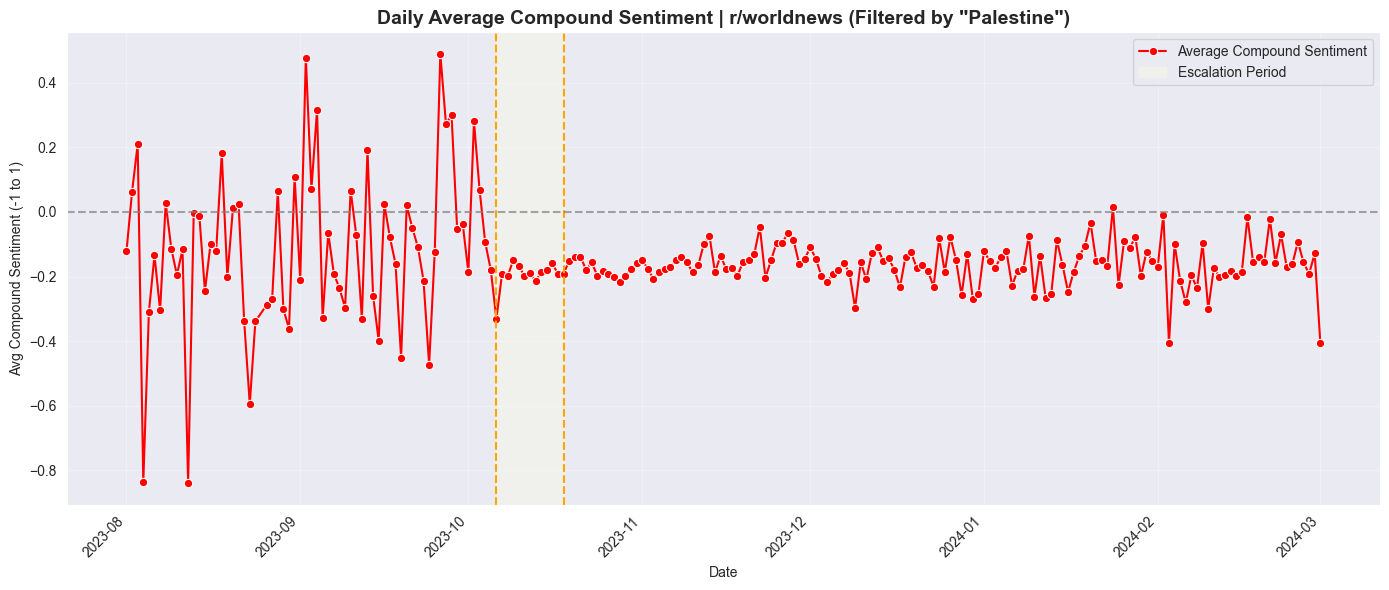

In [34]:
#мабуть видалити
keywords = 'Palestine'
filtered_df = df_comments[
    (df_comments['subreddit'] == 'worldnews') &
    (df_comments['body'].str.contains(keywords, case=False, na=False))
].copy()
filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')
filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

daily_compound = filtered_df.groupby('date')['compound'].mean().reset_index()
daily_compound.columns = ['Date', 'Avg_Compound']

daily_counts = filtered_df['date'].value_counts().sort_index().reset_index()
daily_counts.columns = ['Date', 'Comment_Count']
threshold = daily_counts['Comment_Count'].quantile(0.95)
above_threshold = daily_counts[daily_counts['Comment_Count'] > threshold]
first_date, last_date = None, None
if not above_threshold.empty:
    first_date = above_threshold['Date'].min() - timedelta(days=1)
    last_date = above_threshold['Date'].max()

plt.figure(figsize=(14,6))
sns.lineplot(data=daily_compound, x='Date', y='Avg_Compound', marker='o', color='red', label='Average Compound Sentiment')
if first_date:
    plt.axvspan(first_date, last_date, color='lightyellow', alpha=0.3, label='Escalation Period')
    plt.axvline(first_date, color='orange', linestyle='--')
    plt.axvline(last_date, color='orange', linestyle='--')
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.title('Daily Average Compound Sentiment | r/worldnews (Filtered by "Palestine")', fontsize=14, weight='bold')
plt.xlabel('Date')
plt.ylabel('Avg Compound Sentiment (-1 to 1)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

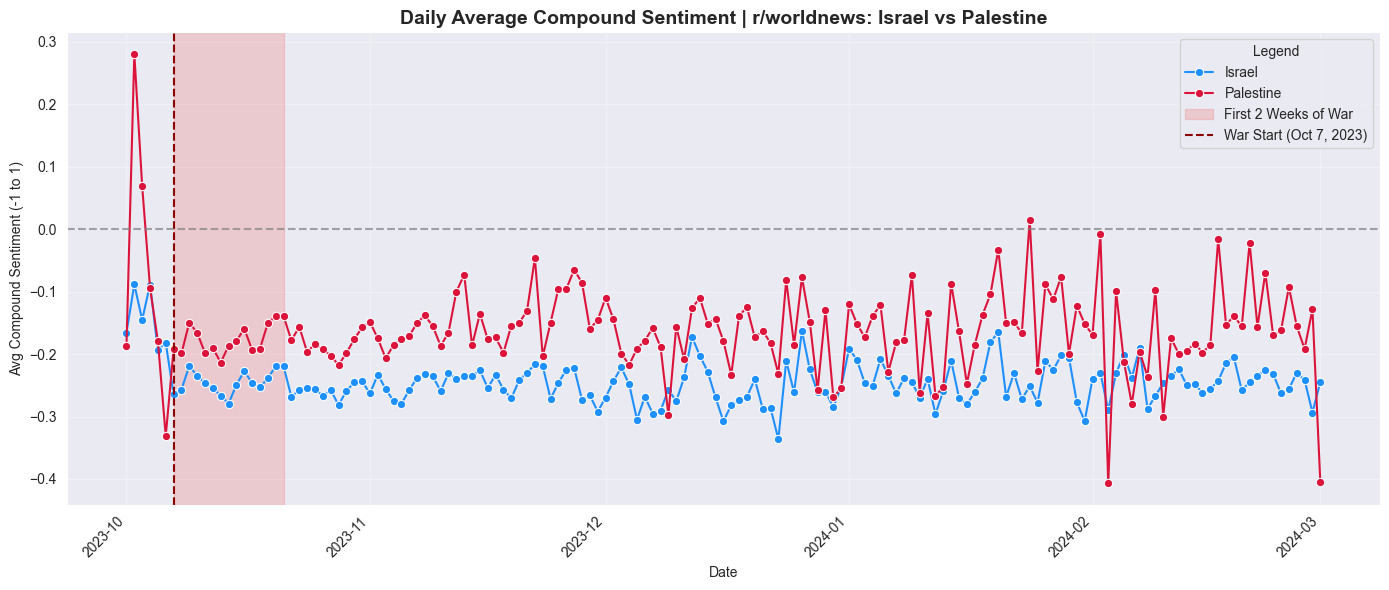

In [37]:
start_date = datetime(2023, 10, 1)
war_start = datetime(2023, 10, 7)
war_end = war_start + timedelta(days=14)  # перші два тижні війни

keywords_list = ['Israel', 'Palestine']
colors = {'Israel': 'dodgerblue', 'Palestine': 'crimson'}

daily_compound_all = []

for keyword in keywords_list:
    df_filtered = df_comments[
        (df_comments['subreddit'] == 'worldnews') &
        (df_comments['body'].str.contains(keyword, case=False, na=False))
    ].copy()

    df_filtered = df_filtered.drop_duplicates(subset=['author', 'body'], keep='first')
    df_filtered['date'] = pd.to_datetime(df_filtered['created']).dt.date

    df_filtered = df_filtered[df_filtered['date'] >= start_date.date()]

    daily_compound = df_filtered.groupby('date')['compound'].mean().reset_index()
    daily_compound['keyword'] = keyword
    daily_compound_all.append(daily_compound)

daily_compound_df = pd.concat(daily_compound_all)

plt.figure(figsize=(14,6))
sns.lineplot(
    data=daily_compound_df,
    x='date',
    y='compound',
    hue='keyword',
    palette=colors,
    marker='o'
)

plt.axvspan(war_start, war_end, color='lightcoral', alpha=0.3, label='First 2 Weeks of War')

plt.axvline(war_start, color='darkred', linestyle='--', label='War Start (Oct 7, 2023)')

plt.axhline(0, color='gray', linestyle='--', alpha=0.7)

plt.title('Daily Average Compound Sentiment | r/worldnews: Israel vs Palestine', fontsize=14, weight='bold')
plt.xlabel('Date')
plt.ylabel('Avg Compound Sentiment (-1 to 1)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.legend(title='Legend', loc='upper right')
plt.tight_layout()
plt.show()


#### 3. Sentiment Analysis of r/worldnews Discussions: "USA" vs. "Ukraine"

This line chart visualizes the Daily Average Compound Sentiment for comments on the r/worldnews subreddit, filtered for the keywords "USA" and "Ukraine", covering the full period of available data. The Compound Sentiment ranges from -1 (most negative) to +1 (most positive).

**Key Timeline Markers:**

War Start (Oct 7, 2023): Marked by a vertical dashed red line, this point signifies the beginning of the major escalation of the conflict.

First 2 Weeks of War (Oct 7 - Oct 21): Shaded in light coral, this area highlights the sentiment during the initial, most intense phase of the conflict.

Zero Line (0.0): A horizontal dashed gray line separates overall positive sentiment (above) from negative sentiment (below).

**Observation:**

USA (blue line): Following the escalation, sentiment toward the USA declined more sharply than toward Ukraine. This suggests a more critical or negative tone emerged in global discussions, possibly reflecting dissatisfaction with US policy, responses, or involvement.

Ukraine (orange line): Sentiment toward Ukraine also dropped during the same period, but the decrease was modest. The discussions remained relatively more neutral or positive compared to those about the USA.

Overall, the chart indicates that the perception of the USA in r/worldnews was affected more negatively than Ukraine during the initial phase of the conflict, but both show clear reactions to the escalation events.




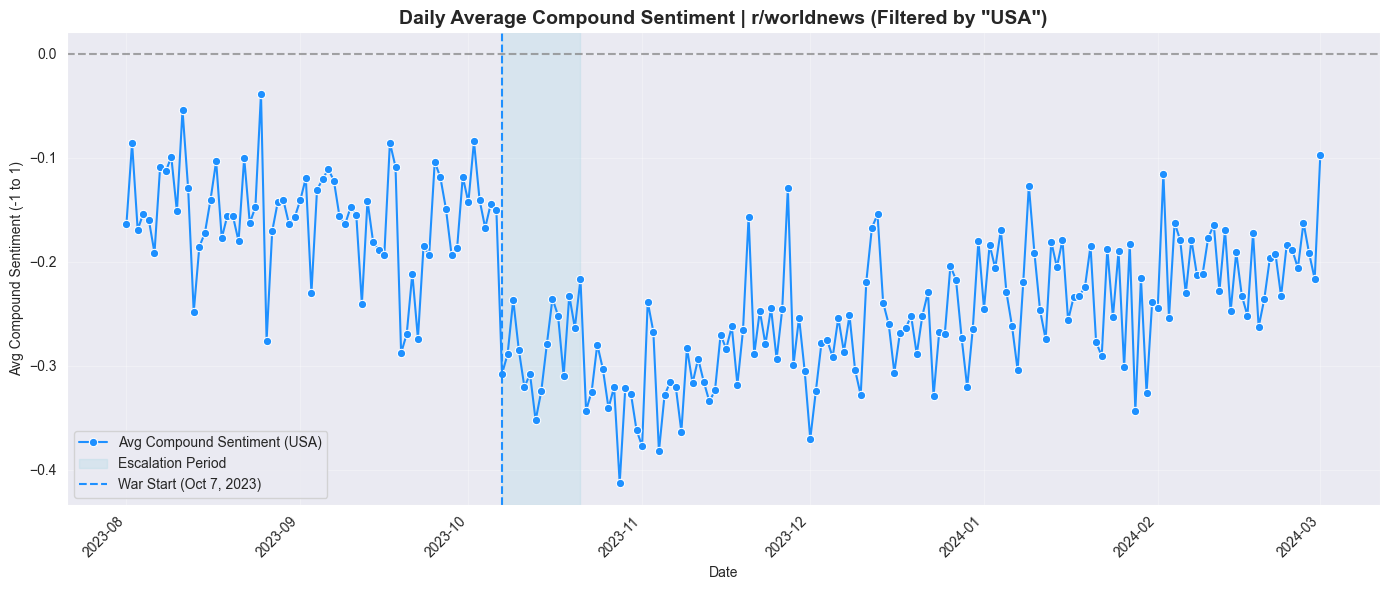

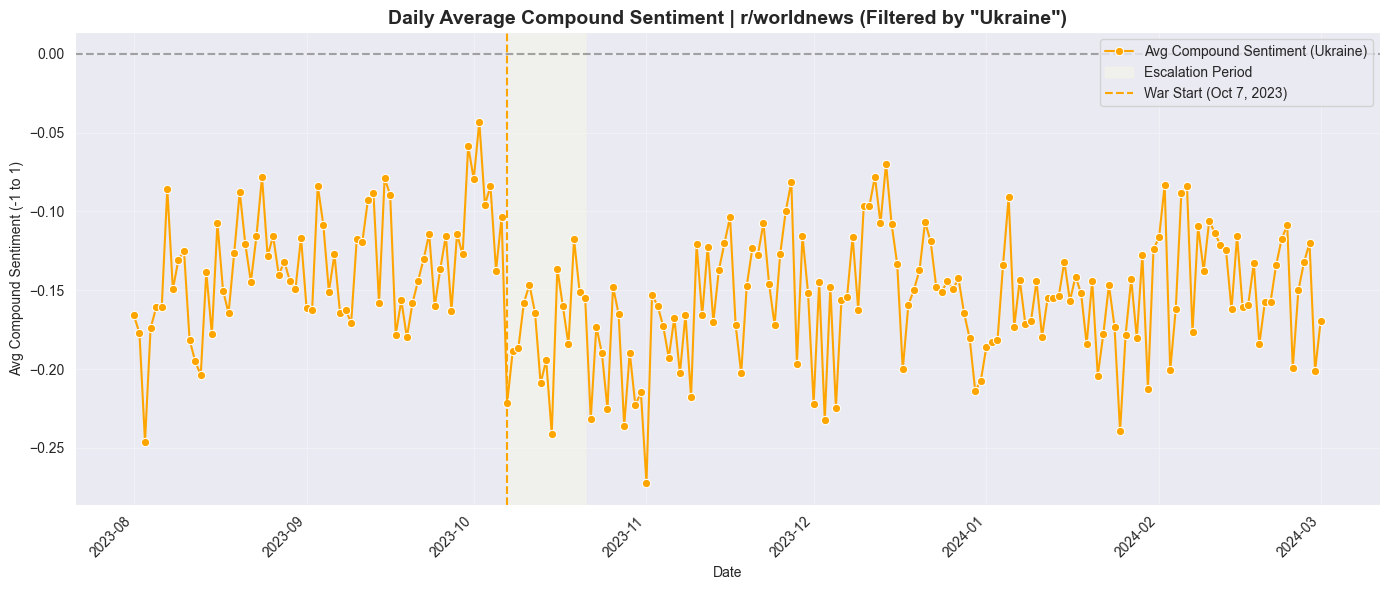

In [43]:
def plot_sentiment_full_period(keyword, line_color, span_color, title):
    # Фільтрація
    filtered_df = df_comments[
        (df_comments['subreddit'] == 'worldnews') &
        (df_comments['body'].str.contains(keyword, case=False, na=False))
    ].copy()

    filtered_df = filtered_df.drop_duplicates(subset=['author', 'body'], keep='first')
    filtered_df['date'] = pd.to_datetime(filtered_df['created']).dt.date

    # Середній compound по днях
    daily_compound = filtered_df.groupby('date')['compound'].mean().reset_index()
    daily_compound.columns = ['Date', 'Avg_Compound']

    plt.figure(figsize=(14,6))
    sns.lineplot(
        data=daily_compound,
        x='Date',
        y='Avg_Compound',
        marker='o',
        color=line_color,
        label=f'Avg Compound Sentiment ({keyword})'
    )

    war_start = datetime(2023, 10, 7)
    war_end = datetime(2023, 10, 21)
    plt.axvspan(war_start, war_end, color=span_color, alpha=0.3, label='Escalation Period')
    plt.axvline(war_start, color=line_color, linestyle='--', label='War Start (Oct 7, 2023)')

    plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel('Date')
    plt.ylabel('Avg Compound Sentiment (-1 to 1)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# США (синій)
plot_sentiment_full_period(
    keyword='USA',
    line_color='dodgerblue',
    span_color='lightblue',
    title='Daily Average Compound Sentiment | r/worldnews (Filtered by "USA")'
)

# Україна (жовтий)
plot_sentiment_full_period(
    keyword='Ukraine',
    line_color='orange',
    span_color='lightyellow',
    title='Daily Average Compound Sentiment | r/worldnews (Filtered by "Ukraine")'
)

#### 4. Top External News Domains in r/Israel and r/Palestine Submissions

This pair of horizontal bar charts visualizes the most frequently cited external news domains in submissions to the r/Israel and r/Palestine subreddits. Only domains outside Reddit and major social platforms (YouTube, Instagram, Twitter/X) are included, focusing on external news coverage. The charts show the top 5 domains for each subreddit, ranked by the number of submissions linking to them.



**Observation:**

***r/Israel (Blue Bars):***

Times of Israel, Jerusalem Post (JPost), Ynetnews, The Guardian, Haaretz
These domains dominate the discussion, highlighting a mixture of Israeli-based and internationally recognized sources. The presence of The Guardian indicates some engagement with global perspectives, while the Israeli sources reflect a strong national media focus.

***r/Palestine (Red Bars):***

Al Jazeera, The Guardian, WSWS.org, Middle East Eye, Reuters
The top domains indicate a preference for Middle Eastern and international sources. Al Jazeera and Middle East Eye provide regional coverage, while WSWS.org represents more niche or opinion-driven content. Reuters appears as the sole mainstream international news agency, suggesting its widespread citation but not dominance.

**Conclusion:**

After excluding social media links, the data reveal distinct informational ecosystems rather than direct platform-based polarization.

r/Israel primarily circulates articles from Israeli national outlets, reflecting a focus on local reporting.

r/Palestine draws on a broader range of regional and global sources, suggesting a more outward-facing perspective on the conflict.
The only major overlap — The Guardian — underscores its role as a widely cited international news outlet across both communities.

In [ ]:
exclude_domains = [
    'reddit.com', 'www.reddit.com', 'np.reddit.com',
    'redd.it', 'v.redd.it', 'i.redd.it',
    'youtube.com', 'www.youtube.com', 'youtu.be', 'www.instagram.com',
    'twitter.com', 'www.twitter.com', 'x.com'
]

df_submissions = df_submissions[
    (~df_submissions['domain'].isin(exclude_domains)) &
    (df_submissions['domain'].notnull()) &
    (df_submissions['domain'] != '')
]

def plot_top_domains(subreddit, color):
    sub_df = (
        df_submissions[df_submissions['subreddit'].str.lower() == subreddit.lower()]
        .groupby('domain')
        .size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
        .head(5)
    )

    if sub_df.empty:
        print(f"No valid domains found for r/{subreddit}")
        return

    plt.figure(figsize=(7, 4))
    sns.barplot(
        data=sub_df,
        x='count',
        y='domain',
        hue='domain',
        dodge=False,
        palette=color,
        legend=False
    )
    plt.title(f"Top External News Domains — r/{subreddit}", fontsize=14, weight='bold')
    plt.xlabel("Number of Submissions")
    plt.ylabel("Domain")
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_top_domains('Israel', 'Blues_r')
plot_top_domains('Palestine', 'Reds_r')

#### 5. Average Sentiment by Subreddit: Conflict-Related Communities

This bar chart presents the average Compound Sentiment (from −1 = most negative to +1 = most positive) across key Reddit communities discussing the Israel–Palestine conflict: r/Israel, r/Palestine, r/IsraelPalestine, r/israelexposed, r/IsraelCrimes, and r/worldnews.

Each bar represents the mean sentiment score for all comments in the subreddit, while the black error bars indicate the standard deviation, showing variability or polarization of sentiment within each community.

Zero Line (0.0):
A vertical dashed gray line marks the neutral point — values to the left represent predominantly negative sentiment, while values to the right indicate positive or supportive sentiment.

**Observation:**

r/israelexposed displays the most negative sentiment, showing strong condemnation or criticism in discussions.

r/IsraelPalestine and r/Palestine also trend negative, reflecting emotionally charged and polarized discourse.

r/worldnews sits near the middle, leaning slightly negative but showing more balanced discussion overall.

r/Israel exhibits a mildly negative tone, while

r/IsraelCrimes stands out as the only subreddit with slightly positive average sentiment, possibly due to more targeted or supportive framing in its discussions.

Overall, the data highlights a clear divide in tone between activist or critical subreddits (strongly negative) and communities focused on specific narratives or informational framing (closer to neutral or positive).

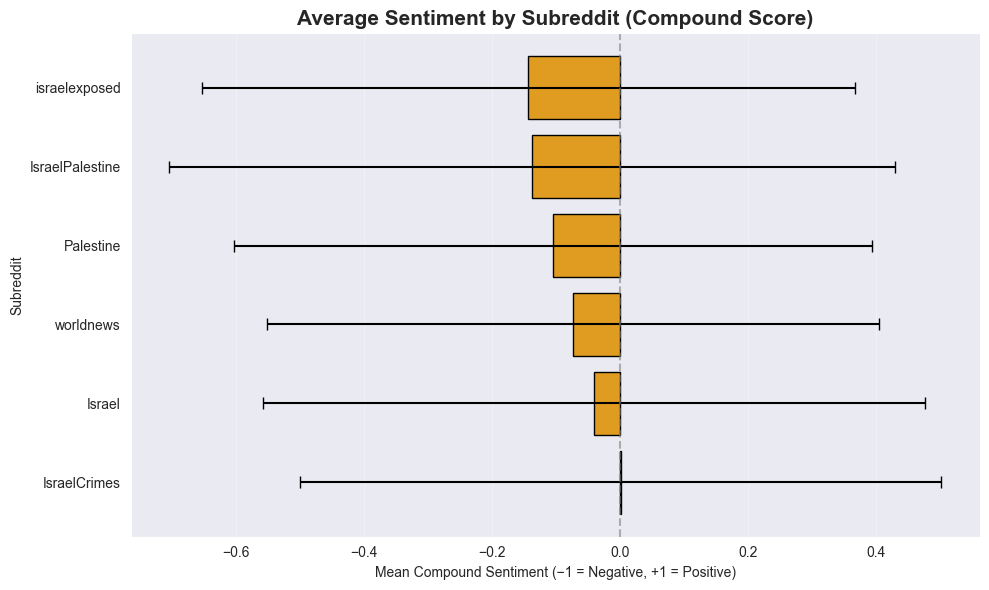

In [67]:
target_subs = ['Israel', 'Palestine', 'IsraelPalestine', 'israelexposed', 'IsraelCrimes', 'worldnews']
df_target = df_comments[df_comments['subreddit'].isin(target_subs)].copy()

sentiment_summary = (
    df_target.groupby('subreddit')['compound']
    .agg(['mean', 'std'])
    .sort_values('mean')
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=sentiment_summary,
    x='mean',
    y='subreddit',
    dodge=False,
    edgecolor='black',
    legend=False,
    color='orange'
)

plt.errorbar(
    sentiment_summary['mean'],
    sentiment_summary['subreddit'],
    xerr=sentiment_summary['std'],
    fmt='none',
    c='black',
    capsize=4,
    label='Sentiment Variability'
)

plt.title("Average Sentiment by Subreddit (Compound Score)", fontsize=15, weight='bold')
plt.xlabel("Mean Compound Sentiment (−1 = Negative, +1 = Positive)")
plt.ylabel("Subreddit")
plt.axvline(0, color='gray', linestyle='--', alpha=0.6)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#### 6. News Source Sentiment Analysis: Top 10 Domains

This horizontal bar chart visualizes the average compound sentiment of Reddit comments in the df_comments dataset, aggregated by the top 10 most active news domains. The sentiment score ranges from -1 (most negative) to +1 (most positive).

**Chart Features:**

X-axis: Average compound sentiment, with a vertical dashed gray line at 0 separating positive (right) from negative (left) sentiment.

Y-axis: News domains, ranked by sentiment from most positive (top) to most negative (bottom).

*Bar Colors:*
Green: Positive average sentiment.
Red: Negative average sentiment.

**Observations:**

Domains such as wallpapercave.com, enforts.com, and ideas.knowme.sbs show positive sentiment, suggesting that Reddit users discuss these sources more favorably or in a neutral-to-positive tone.

Major international news outlets like AlJazeera, BBC, The Guardian, AP News, Times of Israel, and Reuters display negative average sentiment, indicating a more critical or negative perception among Reddit commenters.

The sentiment differences highlight community biases and tone variations depending on the news source, with some outlets consistently eliciting a more critical response.

Also we can see that aljazeera.com, which is Middle East news website has the most negative reactions to the news. It is caused by the impact of the war on their lives.

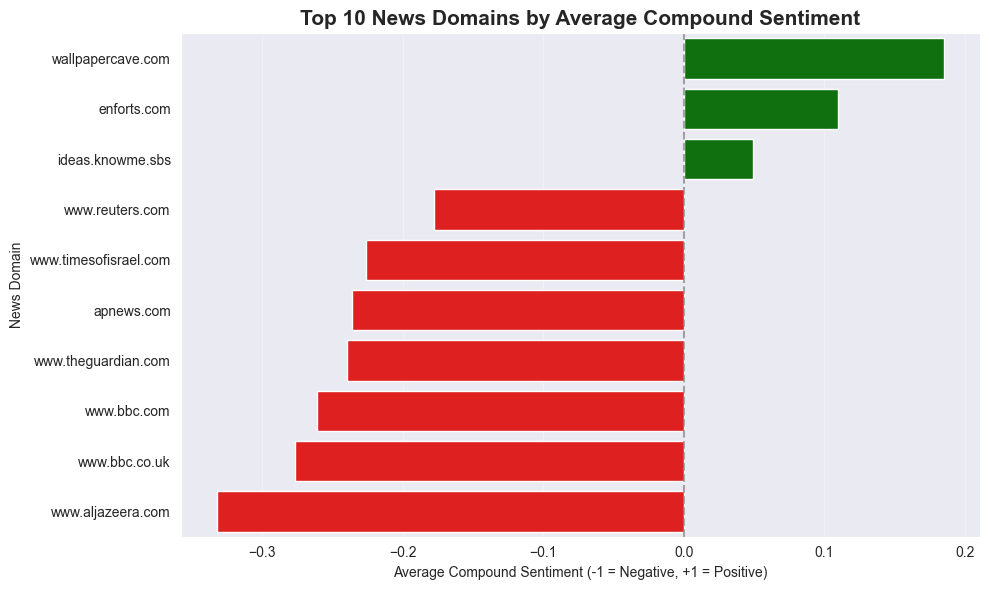

In [61]:
target_subs = ['Israel', 'Palestine', 'IsraelPalestine', 'israelexposed', 'IsraelCrimes', 'worldnews']

exclude_domains = [
    'reddit.com', 'www.reddit.com', 'np.reddit.com',
    'redd.it', 'v.redd.it', 'i.redd.it',
    'youtube.com', 'www.youtube.com', 'youtu.be', 'www.instagram.com',
    'twitter.com', 'www.twitter.com', 'x.com'
]

df_sub_filtered = df_submissions[
    (~df_submissions['domain'].isin(exclude_domains)) &
    (df_submissions['domain'].notnull()) &
    (df_submissions['domain'] != '')
]

df_sub_filtered = df_sub_filtered[df_sub_filtered['subreddit'].isin(target_subs)]

domain_summary = (
    df_sub_filtered.groupby('domain')
    .agg(post_count=('domain', 'size'), avg_sentiment=('compound', 'mean'))
    .reset_index()
)

top_domains = domain_summary.sort_values('post_count', ascending=False).head(10)

top_domains = top_domains.sort_values('avg_sentiment', ascending=False)

colors = ['green' if x > 0 else 'red' for x in top_domains['avg_sentiment']]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_domains,
    x='avg_sentiment',
    y='domain',
    hue='domain',
    dodge=False,
    palette=colors,
    legend=False
)

plt.axvline(0, color='gray', linestyle='--', alpha=0.7)
plt.title('Top 10 News Domains by Average Compound Sentiment', fontsize=15, weight='bold')
plt.xlabel('Average Compound Sentiment (-1 = Negative, +1 = Positive)')
plt.ylabel('News Domain')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# EDA & Graph Analysis: Assumptions and Hypotheses

#### Goal 1: Tone/Sentiment Comparison

1.  **Baseline Polarization:** The baseline sentiment (Aug-Sep 2023) in `r/Israel` for posts mentioning "Israel" will be positive, while the baseline sentiment in `r/Palestine` for posts mentioning "Palestine" will also be positive. However, the sentiment for *crossposted* terms (e.g., "Palestine" in `r/Israel`) will be highly negative, showing strong "in-group" vs. "out-group" sentiment.
2.  **Echo Chamber vs. Debate:** The sentiment *variance* (statistical measure of spread) in `r/IsraelPalestine` will be significantly higher than in `r/Israel` or `r/Palestine`, indicating it functions as a "battleground" or debate forum rather than an echo chamber.
3.  **Specialized Subreddits:** The average sentiment in `r/IsraelCrimes` and `r/israelexposed` will be the most negative of the entire dataset, even more so than `r/Palestine`, and will show less volatility (i.e., it is *consistently* negative).

#### Goal 2: Sentiment Dynamics Over Time

4.  **Volume vs. Sentiment:** The spike in daily comment *volume* (as seen in your notebook) will be strongly correlated with a sharp *drop* in the daily *average sentiment* for all keywords ("Israel," "Hamas," "Gaza," "Palestine").
5.  **Positive Event Spikes:** While the overall sentiment trend will be negative, the daily *count* of positive-sentiment comments will show brief, sharp spikes that correspond to specific dates of announced humanitarian aid deliveries or hostage/prisoner exchanges.
6.  **Keyword Sentiment Divergence:** The average sentiment for comments mentioning "Hamas" will be consistently and strongly negative. In contrast, the sentiment for "Israel" will be more volatile, showing both negative spikes (related to military actions) and positive spikes (related to "defense," "security," or "hostage rescue").

#### Goal 3: Citing News Sources

7.  **Source Partisanship:** Submissions in `r/Israel` will disproportionately cite Israeli and Western news domains (e.g., `jpost.com`, `timesofisrael.com`, `bbc.com`), while submissions in `r/Palestine` will have a significantly higher proportion of citations from sources like `aljazeera.com`, `haaretz.com`, and `middleeasteye.net`.
8.  **Engagement vs. Source:** In `r/worldnews`, the submissions with the highest `score` or `num_comments` will *not* be from the most-cited mainstream sources (like Reuters or AP) but from more opinionated or visually-driven sources (e.g., specific op-eds, video sites).

#### Goal 4: Word Frequency Analysis

9.  **Keyword Co-occurrence:** The frequency of the word "Hezbollah" in comments from `r/Lebanon` and `r/worldnews` will be near-zero in Aug-Sep 2023 and will spike significantly after the initial October 7 escalation.
10. **Temporal Keyword Shift:** A time-series analysis of n-gram frequency will show a shift. In Oct-Nov 2023, the most frequent bigrams related to the conflict will be "Hamas attack" and "hostage." In Jan-Feb 2024, this will shift to "humanitarian aid," "ceasefire," and "famine."
11. **NSFW Content:** The proportion of submissions marked `over_18` will spike in `r/worldnews` and `r/IsraelCrimes` immediately after October 7, and these posts will correlate with a significantly higher negative sentiment.

#### Goal 5: Semantic Evolution & Graph Analysis

12. **Topic Modeling (LDA):** Topic modeling on the `body` of `r/worldnews` comments will show a dominant "conflict" topic (Gaza, Israel, Hamas, attack) emerging in October 2023 that was absent in Aug/Sep.
13. **Graph (Echo Chambers):** A graph where **nodes are authors** and **edges are replies** will show high modularity (clustering) within `r/Israel` and `r/Palestine`. Users will almost exclusively reply to other users with similar sentiment, forming distinct echo chambers. This clustering will be *lower* in `r/IsraelPalestine`.
14. **Graph (Polarization):** In `r/worldnews`, a two-mode graph of (Authors) -> (Submissions) will reveal two large, disconnected clusters of users (those who comment on pro-Israel posts vs. those who comment on pro-Palestine posts). "Bridging" users who comment on both sets of submissions will be rare.
15. **Graph (Power Users):** In the `r/worldnews` user-reply graph, the nodes with the highest **degree centrality** (most replies) during the conflict period will also be the authors with the most negative average sentiment.
16. **Graph (Timezone Activity):** By inferring user timezones from `created` timestamps, a graph analysis will show that during the conflict spike (post-Oct 7), reply activity becomes *less* clustered by timezone. This suggests users are engaging across timezones (i.e., staying up late) more than during the baseline period.
17. **Graph (Ideological Bridging):** In the user-reply graph for `r/IsraelPalestine`, identify users with high **betweenness centrality**. These "bridging" users, who connect otherwise separate communities, will have an average sentiment score closer to neutral than the highly polarized users they connect.